In [1]:
import gempyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob, os, sys, re, shutil
from pathlib import Path

# import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import subprocess
import dask.dataframe as dd
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

import os
import multiprocessing as mp
import pandas as pd
import pyarrow.parquet as pq
from gempyor import config, model_info, outcomes, seir

import os
from multiprocessing import cpu_count

# disable  operations using the MKL linear algebra.
os.environ["OMP_NUM_THREADS"] = "1"
import emcee

from multiprocessing import Pool
from gempyor_logprob import log_prob, compute_likelyhood, check_in_bounds, run_simulation, input_proposal




data_dir = "RSV_USA/"
import os
os.chdir(data_dir)
data_dir = "."  # necessary for now for time serie parameters !!! fixme 

In [4]:
config_path = f"config_rsvnet_emcee.yml"
nwalkers = 256
config_path = f"config_CACOMD_maternal_v8_emcee.yml"
nwalkers = 128
niter = 400
nsamples = 100 # number of likelyhood eval to write to disk...
thin=5

ncpu = cpu_count()
print(f"found {ncpu} CPUs, using these")


found 12 CPUs, using these


In [5]:

run_id = config_path.split(".")[0]

config.clear()
config.read(user=False)
config.set_file(config_path)
print(config_path)


seir_modifiers_scenario="none"
outcome_modifiers_scenario="IHRadj"

in_run_id = run_id
out_run_id = in_run_id
in_prefix = f"emcee_{run_id}"

out_prefix = in_prefix

write_csv = False
write_parquet = True
modinf = model_info.ModelInfo(
    config=config,
    nslots=1,
    seir_modifiers_scenario=seir_modifiers_scenario,
    outcome_modifiers_scenario=outcome_modifiers_scenario,
    write_csv=write_csv,
    write_parquet=write_parquet,
    first_sim_index=1,
    in_run_id=in_run_id,
    in_prefix=in_prefix,
    inference_filename_prefix="no",
    inference_filepath_suffix="no",
    out_run_id=out_run_id,
    out_prefix=out_prefix,
    stoch_traj_flag=False,
)

nsubpop = len(modinf.subpop_struct.subpop_names)
subpop_names = modinf.subpop_struct.subpop_names

CRITICAL:root:No mobility matrix specified -- assuming no one moves


config_CACOMD_maternal_v8_emcee.yml


In [6]:
# find what to perturb
fitted_params = {
    "ptype":[],
    "pname":[],
    "subpop":[],
    "pdist":[],
    "ub":[],
    "lb":[],
}
ndim=0

print(f"there are {nsubpop} subpop in the config")

print("SEIR MODIFIERS")
for npi in gempyor.config["seir_modifiers"]["modifiers"].get():
    if gempyor.config["seir_modifiers"]["modifiers"][npi]["perturbation"].exists():
        c = config["seir_modifiers"]["modifiers"][npi]
        for sp in modinf.subpop_struct.subpop_names:
            fitted_params["ptype"].append("snpi")
            fitted_params["pname"].append(npi)
            fitted_params["subpop"].append(sp)
            fitted_params["pdist"].append(c["value"].as_random_distribution())
            fitted_params["lb"].append(c["value"]["a"].get())
            fitted_params["ub"].append(c["value"]["b"].get())
            ndim+=1
        print(f" >> {npi} has perturbation, recording")
        
print("OUTCOMES MODIFIERS")   
for npi in gempyor.config["outcome_modifiers"]["modifiers"].get():
    if gempyor.config["outcome_modifiers"]["modifiers"][npi]["perturbation"].exists():
        c = config["outcome_modifiers"]["modifiers"][npi]
        for sp in modinf.subpop_struct.subpop_names:
            fitted_params["ptype"].append("hnpi")
            fitted_params["pname"].append(npi)
            fitted_params["subpop"].append(sp)
            fitted_params["pdist"].append(c["value"].as_random_distribution())
            fitted_params["lb"].append(c["value"]["a"].get())
            fitted_params["ub"].append(c["value"]["b"].get())
            ndim+=1
        print(f" >> {npi} has perturbation, recording")


# TODO: does not support the subpop groups here !!!!!!!
print(f"The dimension of the parameter space is {ndim}!!")

there are 3 subpop in the config
SEIR MODIFIERS
 >> Ro_mod has perturbation, recording
 >> covid_mod has perturbation, recording
 >> omicron_mod has perturbation, recording
 >> seas_amp_mod has perturbation, recording
 >> seas_offset_mod has perturbation, recording
OUTCOMES MODIFIERS
 >> IHRadj_age0to11m has perturbation, recording
 >> IHRadj_age1to4 has perturbation, recording
 >> IHRadj_age5to17 has perturbation, recording
 >> IHRadj_age18to49 has perturbation, recording
 >> IHRadj_age50to64 has perturbation, recording
 >> IHRadj_age65to100 has perturbation, recording
The dimension of the parameter space is 33!!


In [7]:
# Find the ground-truth
gt = pd.read_csv(f"{data_dir}/"+gempyor.config["inference"]["gt_data_path"].get())
# gt
statistics = {}
# # Ingoring agreegation and all, assuming by weekP
for stat in gempyor.config["inference"]["statistics"]:
    statistics[gempyor.config["inference"]["statistics"][stat]["sim_var"].get()] = gempyor.config["inference"]["statistics"][stat]["data_var"].get()
statistics
gt = gempyor.read_df(gempyor.config["inference"]["gt_data_path"].get())
gt["date"]= pd.to_datetime(gt['date'])
gt = gt.set_index("date")

## Create the first gempyor object

In [8]:

print("MAKING A TEST RUN TO GET SETUP")
(
    unique_strings,
    transition_array,
    proportion_array,
    proportion_info,
) = modinf.compartments.get_transition_array()

outcomes_parameters = outcomes.read_parameters_from_config(modinf)


npi_seir = seir.build_npi_SEIR(
    modinf=modinf, load_ID=False, sim_id2load=None, config=config
)
if modinf.npi_config_outcomes:
    npi_outcomes = outcomes.build_outcome_modifiers(
                modinf=modinf,
                load_ID=False,
                sim_id2load=None,
                config=config,
            )

p_draw = modinf.parameters.parameters_quick_draw(
                n_days=modinf.n_days, nsubpops=modinf.nsubpops
            )

initial_conditions = modinf.initial_conditions.get_from_config(sim_id=0, setup=modinf)
seeding_data, seeding_amounts = modinf.seeding.get_from_config(sim_id=0, setup=modinf)



# reduce them
parameters = modinf.parameters.parameters_reduce(p_draw, npi_seir)
        # Parse them
parsed_parameters = modinf.compartments.parse_parameters(
    parameters, modinf.parameters.pnames, unique_strings
)

states = seir.steps_SEIR(
    modinf,
    parsed_parameters,
    transition_array,
    proportion_array,
    proportion_info,
    initial_conditions,
    seeding_data,
    seeding_amounts,
)

seir_out_df_ref = seir.postprocess_and_write(
    0, modinf, states, p_draw, npi_seir, seeding_data
)
snpi_df_ref = npi_seir.getReductionDF()

outcomes_df, hpar_df = outcomes.compute_all_multioutcomes(
    modinf=modinf,
    sim_id2write=0,
    parameters=outcomes_parameters,
    loaded_values=None,
    npi=npi_outcomes,
    bypass_seir=seir_out_df_ref
)
outcomes_df_ref, hpar_ref, hnpi_df_ref = outcomes.postprocess_and_write(
    sim_id=0,
    modinf=modinf,
    outcomes_df=outcomes_df,
    hpar=hpar_df,
    npi=npi_outcomes,
)

outcomes_df_ref = outcomes_df_ref.set_index("date")
print("TEST RUN IS DONE")

MAKING A TEST RUN TO GET SETUP


INFO:root:[SEIR.compartments] completed in 4.35 s
INFO:root:[Outcome.structure] completed in 0.00 s
INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s


ERROR: subpop_names California (idx: pl_idx) has a population from initial condition of 39512224.00000008 while population from geodata is 39512223 (absolute difference should be < 1, here is 1.0000000819563866)
 Ignoring the previous population mismatch errors because you added flag 'ignore_population_checks'. This is dangerous


INFO:root:Integrating with method rk4.jit
6758it [00:33, 201.67it/s]


TEST RUN IS DONE


In [9]:
# need to convert to numba dict to python dict so it is pickable
seeding_data = dict(seeding_data)

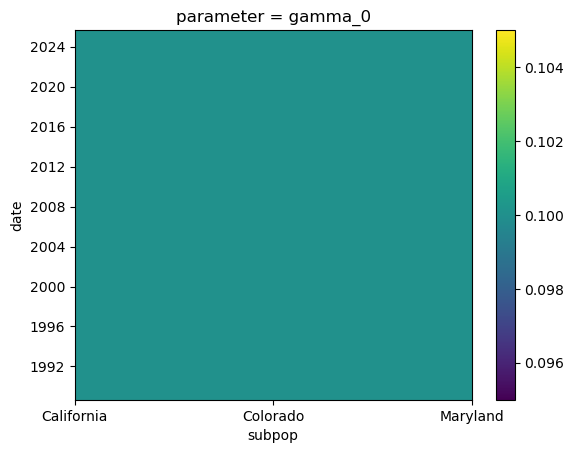

In [10]:
import xarray as xr
xr.DataArray(p_draw, dims=["parameter", "date", "subpop"],  
                coords={"parameter":modinf.parameters.pnames, 
                "date":pd.date_range(modinf.ti, modinf.tf, freq="D"), 
                "subpop":modinf.subpop_struct.subpop_names}).sel(parameter="gamma_0").plot()

In [ ]:
if False:
    outcomes_df = run_simulation(snpi_df_in=snpi_df_ref, hnpi_df_in=hnpi_df_ref)
    outcomes_df_ref.set_index("date")["incidH"].plot(lw=2, c='k')
    outcomes_df.set_index("date")["incidH"].plot(lw=1, c='r')

In [ ]:
#proposal = np.random.random(size=ndim)
#print(log_prob(proposal))
#proposal = np.random.random(size=ndim)*2
#print(log_prob(proposal))

In [11]:

# find the initial point from the chain:
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:,i] = fitted_params["pdist"][i](nwalkers)
    # DOES not take subpop groups into consideration !!!!!!

In [ ]:
#print(fitted_params["lb"])
#print(p0)
#print(fitted_params["ub"])

In [ ]:


print(f"initial run llik {compute_likelyhood(outcomes_df_ref, gt, modinf, statistics)}")


In [12]:
for i in range(nwalkers):
    assert check_in_bounds(p0[i], fitted_params)

## Run EMCEE

In [ ]:
filename = f"{run_id}_backend.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool(ncpu) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob,
                                    args=[snpi_df_ref, ndim, statistics, fitted_params, gt, hnpi_df_ref, modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters, False], 
                                    pool=pool,
                                    backend=backend, moves=[(emcee.moves.StretchMove(live_dangerously=True), 1)])
    state = sampler.run_mcmc(p0, niter, progress=True, skip_initial_state_check=True)

In [ ]:
backend = emcee.backends.HDFBackend(filename)
with Pool(ncpu) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, 
                                    args=[snpi_df_ref, ndim, statistics, fitted_params, gt, hnpi_df_ref, modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters, True], 
                                    pool=pool,
                                    backend=backend,  moves=[(emcee.moves.StretchMove(live_dangerously=True), 1)])
    state = sampler.run_mcmc(None, (nsamples//nwalkers)+1, progress=True, skip_initial_state_check=True)

In [ ]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

#print(
#    "Mean autocorrelation time: {0:.3f} steps".format(
#        np.mean(sampler.get_autocorr_time())
#    )
#)

In [ ]:
plt.plot(sampler.acceptance_fraction)

## Analysi

In [13]:
filename = f"../ll/{run_id}_backend.h5"
sampler = emcee.backends.HDFBackend(filename, read_only=True)

In [ ]:
# todo: restart form other shape...

In [14]:
last_llik = sampler.get_log_prob()[-1,:]
good_slots = last_llik > (last_llik.mean()-1*last_llik.std())
print(f"there are {good_slots.sum()}/{len(good_slots)} bad walkers... disregarding these")

there are 112/128 bad walkers... disregarding these


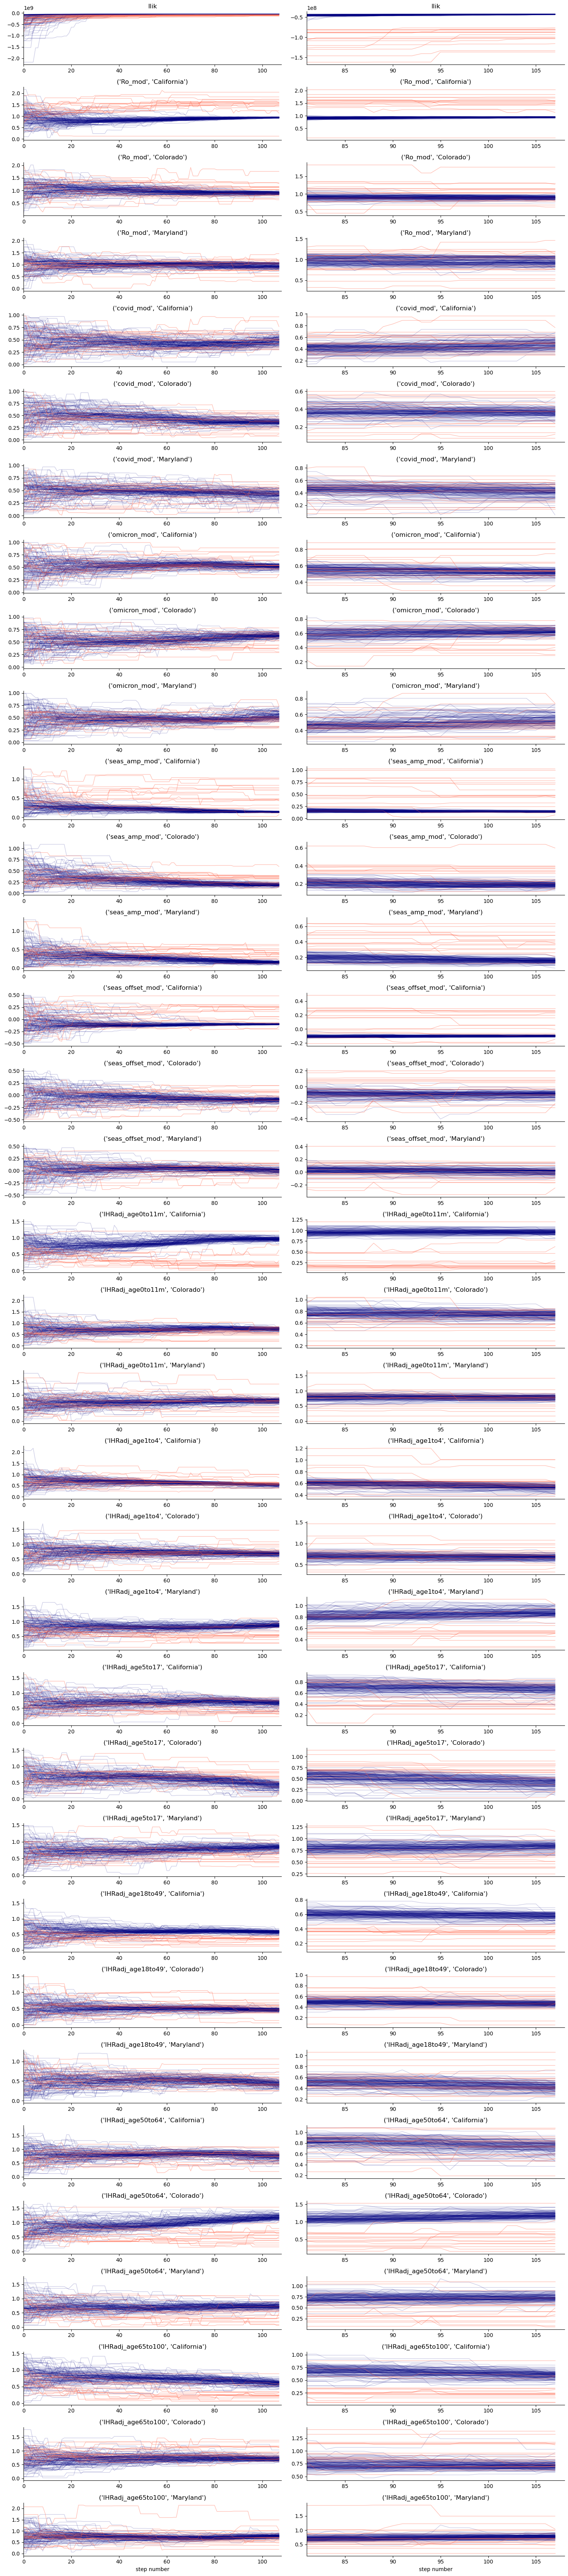

In [15]:
fig, axes = plt.subplots(ndim+1,2, figsize=(15, (ndim+1)*2))

labels = list(zip(fitted_params["pname"], fitted_params["subpop"]))
samples = sampler.get_chain()

import seaborn as sns
def plot_chain(frompt,axes):
    ax = axes[0]

    ax.plot(np.arange(frompt,frompt+sampler.get_log_prob()[frompt:].shape[0]),
                      sampler.get_log_prob()[frompt:,good_slots], "navy", alpha=.2, lw=1, label="good walkers")
    ax.plot(np.arange(frompt,frompt+sampler.get_log_prob()[frompt:].shape[0]),
            sampler.get_log_prob()[frompt:,~good_slots], "tomato", alpha=.4, lw=1, label="bad walkers")
    ax.set_title("llik")
    #ax.legend()
    sns.despine(ax=ax, trim=False)
    ax.set_xlim(frompt, frompt+sampler.get_log_prob()[frompt:].shape[0])

    #ax.set_xlim(0, len(samples))

    for i in range(ndim):
        ax = axes[i+1]
        ax.plot(np.arange(frompt,frompt+sampler.get_log_prob()[frompt:].shape[0]),
                samples[frompt:,good_slots, i], "navy", alpha=.2, lw=1,)
        ax.plot(np.arange(frompt,frompt+sampler.get_log_prob()[frompt:].shape[0]),
                samples[frompt:, ~good_slots, i], "tomato", alpha=.4, lw=1,)
        #ax.set_xlim(0, len(samples))
        ax.set_title(labels[i])
        #ax.yaxis.set_label_coords(-0.1, 0.5)
        sns.despine(ax=ax, trim=False)
        ax.set_xlim(frompt, frompt+samples[frompt:].shape[0])
        

    axes[-1].set_xlabel("step number");

plot_chain(0,axes[:,0])
plot_chain(3*samples.shape[0]//4,axes[:,1])
fig.tight_layout()

plt.savefig(f"{run_id}_chains.pdf")

In [17]:
good_samples =  sampler.get_chain()[:,good_slots,:]
good_samples.shape

(108, 112, 33)

In [18]:
step_number = -1
exported_samples = np.empty((nsamples,ndim))
for i in range(nsamples):
    exported_samples[i,:] = good_samples[step_number - thin*(i//(good_slots.sum())) ,i%(good_slots.sum()),:] # parentesis around i//(good_slots.sum() are very important

In [33]:
position_arguments = [snpi_df_ref, ndim, statistics, fitted_params, gt, hnpi_df_ref, modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters, True]

with Pool(ncpu) as pool:
    results = pool.starmap(log_prob, [(sample, *position_arguments) for sample in exported_samples])

RRRRR is 87873647
RRRRR is 38837035
RRRRR is 70973425
RRRRR is 90110626
RRRRR is 45743278
RRRRR is 24334240
RRRRR is 65095567
RRRRR is 31700407
RRRRR is 46880630
RRRRR is 43530458
RRRRR is 96911520
RRRRR is 71055604


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.17 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.21 

llik is -43169619.35808038
RRRRR is 12573955


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s


llik is -43651079.44564867
RRRRR is 82159937


INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.45 s


llik is -42281724.134733506
RRRRR is 71154315


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.36 s


llik is -43339598.65447778
RRRRR is 32388992


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s


llik is -43382463.67917495
RRRRR is 56436136


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.40 s
84it [00:03, 70.99it/s]INFO:root:Integrating with method rk4.jit
166it [00:03, 115.74it/s]INFO:root:Integrating with method rk4.jit
184it [00:03, 130.66it/s]

llik is -43067112.484789856
RRRRR is 33353798


INFO:root:[SEIR.NPI] completed in 0.07 s
225it [00:04, 117.63it/s]INFO:root:[Outcomes.Modifiers] completed in 0.36 s
250it [00:04, 117.50it/s]INFO:root:Integrating with method rk4.jit
323it [00:04, 130.20it/s]INFO:root:[SEIR.NPI] completed in 0.09 s


llik is -43065295.61860891
RRRRR is 53063074


365it [00:05, 126.68it/s]INFO:root:[Outcomes.Modifiers] completed in 0.39 s
28it [00:02, 17.79it/s]s]

llik is -43275412.10155422
RRRRR is 2726838
llik is -43416180.09485274
RRRRR is 52971189


422it [00:05, 134.20it/s]INFO:root:[SEIR.NPI] completed in 0.07 s
43it [00:02, 30.63it/s]INFO:root:[SEIR.NPI] completed in 0.06 s
71it [00:02, 57.41it/s]INFO:root:[Outcomes.Modifiers] completed in 0.26 s
465it [00:06, 132.32it/s]INFO:root:[Outcomes.Modifiers] completed in 0.29 s
85it [00:02, 70.86it/s]

llik is -43329485.399969764
RRRRR is 42533672


101it [00:03, 87.46it/s]INFO:root:[SEIR.NPI] completed in 0.06 s
97it [00:02, 76.10it/s]INFO:root:[Outcomes.Modifiers] completed in 0.36 s
148it [00:03, 106.50it/s]INFO:root:[SEIR.NPI] completed in 0.08 s
200it [00:03, 118.67it/s]INFO:root:Integrating with method rk4.jit
163it [00:03, 115.37it/s]

llik is -42633234.802494034
RRRRR is 74196559


191it [00:03, 122.90it/s]

llik is -42674035.17095028
RRRRR is 47928977


INFO:root:[Outcomes.Modifiers] completed in 0.32 s
124it [00:02, 115.77it/s]INFO:root:[SEIR.NPI] completed in 0.06 s
268it [00:04, 112.29it/s]INFO:root:[Outcomes.Modifiers] completed in 0.36 s
322it [00:04, 121.24it/s]INFO:root:Integrating with method rk4.jit
336it [00:04, 128.43it/s]INFO:root:Integrating with method rk4.jit
925it [00:09, 127.18it/s]INFO:root:Integrating with method rk4.jit
533it [00:06, 143.16it/s]INFO:root:Integrating with method rk4.jit
120it [00:03, 98.76it/s]]INFO:root:Integrating with method rk4.jit
638it [00:06, 130.46it/s]INFO:root:Integrating with method rk4.jit
639it [00:06, 152.24it/s]INFO:root:Integrating with method rk4.jit
6758it [00:45, 148.40it/s]
6758it [00:43, 155.08it/s]
6758it [00:45, 150.08it/s]
6758it [00:45, 149.48it/s]
6758it [00:44, 150.25it/s]
6758it [00:45, 147.83it/s]
6758it [00:47, 141.42it/s]
6758it [00:47, 143.29it/s]
6758it [00:45, 147.76it/s]
6758it [00:47, 143.08it/s]
6758it [00:48, 139.46it/s]
6758it [00:50, 132.57it/s]


llik is -43129823.911782466
RRRRR is 51581620


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.49 s


llik is -43017756.833466336
RRRRR is 29112306


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.33 s


llik is -43465368.99552769
RRRRR is 52350997


INFO:root:[SEIR.NPI] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

llik is -42628441.31350993
RRRRR is 35401038


INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
1it [00:01,  1.79s/it]INFO:root:[SEIR.NPI] completed in 0.07 s
20it [00:01, 14.51it/s]

llik is -42695466.19502677
RRRRR is 94488063


64it [00:02, 50.64it/s]INFO:root:[Outcomes.Modifiers] completed in 0.45 s
76it [00:02, 59.89it/s]INFO:root:Integrating with method rk4.jit
198it [00:03, 134.29it/s]INFO:root:Integrating with method rk4.jit
307it [00:04, 143.31it/s]INFO:root:Integrating with method rk4.jit
226it [00:03, 145.69it/s]INFO:root:Integrating with method rk4.jit
475it [00:04, 129.56it/s]

llik is -42974729.34482247
RRRRR is 91240401


821it [00:07, 163.14it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
340it [00:03, 167.22it/s]INFO:root:[Outcomes.Modifiers] completed in 0.42 s
471it [00:04, 148.26it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
106it [00:02, 92.94it/s]]

llik is -43127824.00228261
RRRRR is 21684862
llik is -42995669.560395464
RRRRR is 2853609


INFO:root:[SEIR.NPI] completed in 0.06 s
394it [00:04, 142.45it/s]INFO:root:[Outcomes.Modifiers] completed in 0.27 s
153it [00:02, 102.31it/s]INFO:root:[Outcomes.Modifiers] completed in 0.46 s
1044it [00:09, 143.20it/s]

llik is -42746440.43226068
RRRRR is 41887569


513it [00:05, 141.79it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
543it [00:05, 135.27it/s]INFO:root:[Outcomes.Modifiers] completed in 0.23 s
INFO:root:[SEIR.NPI] completed in 0.07 s
557it [00:05, 134.09it/s]]

llik is -43121011.465036996
RRRRR is 9571927


333it [00:04, 132.41it/s]INFO:root:[Outcomes.Modifiers] completed in 0.36 s
802it [00:07, 139.18it/s]]

llik is -43149126.972979136
RRRRR is 83890338


INFO:root:[SEIR.NPI] completed in 0.05 s
413it [00:04, 149.40it/s]INFO:root:[Outcomes.Modifiers] completed in 0.36 s
1372it [00:11, 143.54it/s]INFO:root:Integrating with method rk4.jit
818it [00:07, 124.53it/s]]

llik is -42988273.20057827
RRRRR is 85582144


973it [00:08, 157.55it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
860it [00:07, 130.32it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.29 s
1040it [00:08, 158.25it/s]INFO:root:Integrating with method rk4.jit
765it [00:07, 131.39it/s]INFO:root:Integrating with method rk4.jit
1703it [00:13, 145.45it/s]INFO:root:Integrating with method rk4.jit
1341it [00:11, 144.26it/s]INFO:root:Integrating with method rk4.jit
326it [00:03, 163.70it/s]INFO:root:Integrating with method rk4.jit
6758it [00:41, 163.30it/s]
6758it [00:40, 167.32it/s]
6758it [00:41, 161.57it/s]
6758it [00:40, 166.01it/s]
6758it [00:41, 162.55it/s]
6758it [00:40, 168.53it/s]
6758it [00:40, 167.69it/s]
6758it [00:43, 155.28it/s]
6758it [00:42, 157.83it/s]
6758it [00:45, 149.79it/s]
6758it [00:45, 149.15it/s]
6339it [00:44, 113.70it/s]

llik is -42390520.76669884


6366it [00:44, 115.74it/s]

RRRRR is 83638220


6439it [00:44, 107.08it/s]INFO:root:[SEIR.NPI] completed in 0.60 s
6454it [00:45, 117.42it/s]INFO:root:[Outcomes.Modifiers] completed in 0.10 s
6733it [00:47, 124.02it/s]

llik is -43094720.453847416


6758it [00:47, 142.25it/s]


RRRRR is 18453707


INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s


llik is -43335744.48304293
llik is -43072989.244072095


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

RRRRR is 34612468


INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.16 s


RRRRR is 97035141


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.20 s
65it [00:03, 41.80it/s]

llik is -42694698.41202898


75it [00:03, 49.03it/s]INFO:root:Integrating with method rk4.jit
129it [00:03, 103.50it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
142it [00:03, 109.67it/s]

RRRRR is 3884207


158it [00:04, 122.14it/s]INFO:root:[Outcomes.Modifiers] completed in 0.21 s
285it [00:05, 129.03it/s]INFO:root:Integrating with method rk4.jit
339it [00:05, 129.28it/s]INFO:root:Integrating with method rk4.jit
109it [00:03, 90.67it/s]INFO:root:Integrating with method rk4.jit
334it [00:05, 116.52it/s]

llik is -43192633.452855706


244it [00:04, 110.99it/s]

RRRRR is 95775830


INFO:root:[SEIR.NPI] completed in 0.07 s
817it [00:10, 113.16it/s]INFO:root:[Outcomes.Modifiers] completed in 0.31 s
136it [00:04, 97.32it/s]]]

llik is -43306691.46515275


196it [00:04, 126.60it/s]]

RRRRR is 36496399


663it [00:08, 148.95it/s]INFO:root:[SEIR.NPI] completed in 0.06 s
226it [00:04, 120.37it/s]INFO:root:[Outcomes.Modifiers] completed in 0.20 s
654it [00:08, 122.12it/s]INFO:root:Integrating with method rk4.jit
549it [00:07, 136.68it/s]]

llik is -42540883.02274315


1004it [00:10, 139.81it/s]INFO:root:[SEIR.NPI] completed in 0.04 s
1649it [00:16, 137.37it/s]

RRRRR is 27811150


126it [00:02, 106.87it/s]INFO:root:[Outcomes.Modifiers] completed in 0.16 s
1182it [00:11, 136.94it/s]

llik is -43022726.70028531


209it [00:03, 137.22it/s]INFO:root:Integrating with method rk4.jit
246it [00:03, 159.70it/s]]

RRRRR is 7618931


761it [00:08, 139.83it/s]INFO:root:[SEIR.NPI] completed in 0.07 s
1271it [00:12, 142.28it/s]INFO:root:[Outcomes.Modifiers] completed in 0.19 s
312it [00:03, 147.34it/s]]

llik is -42889643.292379625


852it [00:09, 139.68it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
1463it [00:14, 142.46it/s]

RRRRR is 7821977


1889it [00:18, 140.71it/s]INFO:root:[Outcomes.Modifiers] completed in 0.19 s
994it [00:10, 148.03it/s]]

llik is -42721616.33582993
RRRRR is 36333077


1560it [00:14, 151.16it/s]INFO:root:[SEIR.NPI] completed in 0.39 s
1576it [00:14, 147.92it/s]INFO:root:[Outcomes.Modifiers] completed in 0.12 s
1127it [00:11, 132.81it/s]INFO:root:Integrating with method rk4.jit
1262it [00:12, 143.49it/s]INFO:root:Integrating with method rk4.jit
1359it [00:13, 149.29it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

llik is -43239554.57416531


1795it [00:16, 130.49it/s]INFO:root:[SEIR.NPI] completed in 0.04 s
1406it [00:13, 128.63it/s]

RRRRR is 32069080


2450it [00:22, 151.88it/s]INFO:root:[Outcomes.Modifiers] completed in 0.22 s
248it [00:03, 142.39it/s]INFO:root:Integrating with method rk4.jit
1918it [00:16, 154.19it/s]INFO:root:Integrating with method rk4.jit
6758it [00:46, 146.22it/s]
6758it [00:43, 154.35it/s]
6758it [00:45, 147.59it/s]
6758it [00:44, 153.56it/s]
6758it [00:44, 152.69it/s]
6758it [00:42, 159.79it/s]
6758it [00:43, 156.09it/s]
6758it [00:45, 147.60it/s]
6258it [00:49, 45.19it/s]

llik is -43449527.83875287
RRRRR is 7212034


6235it [00:51, 31.26it/s]INFO:root:[SEIR.NPI] completed in 0.18 s
6758it [00:53, 126.28it/s]
5555it [00:48, 52.40it/s]INFO:root:[Outcomes.Modifiers] completed in 1.27 s
6695it [01:06, 81.35it/s]

llik is -43245551.99520913
RRRRR is 4099198


6701it [01:08, 84.30it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
6738it [01:06, 98.80it/s]

llik is -43182581.643254265
RRRRR is 62387904


6748it [01:06, 97.51it/s]INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.47 s
6758it [01:06, 101.21it/s]
6758it [01:08, 98.27it/s]
6051it [01:05, 96.50it/s]INFO:root:[Outcomes.Modifiers] completed in 0.62 s
6076it [01:05, 99.51it/s] INFO:root:Integrating with method rk4.jit
6141it [01:06, 69.91it/s] 

llik is -42632438.30784247
RRRRR is 80719253


6152it [01:06, 78.24it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
6213it [01:07, 108.97it/s]INFO:root:[Outcomes.Modifiers] completed in 0.49 s
6448it [01:09, 109.30it/s]INFO:root:Integrating with method rk4.jit
6497it [01:09, 102.89it/s]INFO:root:Integrating with method rk4.jit
6655it [01:11, 114.44it/s]INFO:root:[SEIR.NPI] completed in 0.08 s
248it [00:05, 130.90it/s]

llik is -42631542.96991843
RRRRR is 60506599


6667it [01:11, 111.96it/s]INFO:root:Integrating with method rk4.jit
291it [00:05, 129.20it/s]INFO:root:[Outcomes.Modifiers] completed in 0.41 s
6758it [01:11, 93.99it/s] 
315it [00:05, 95.75it/s]INFO:root:[SEIR.NPI] completed in 0.10 s


llik is -43675650.20821168
RRRRR is 69428698


342it [00:05, 84.18it/s] INFO:root:[Outcomes.Modifiers] completed in 0.32 s
487it [00:06, 110.67it/s]INFO:root:Integrating with method rk4.jit
115it [00:03, 74.79it/s]INFO:root:Integrating with method rk4.jit
1291it [00:15, 116.92it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
760it [00:09, 124.53it/s]

llik is -42454175.70232597
RRRRR is 36488340


1043it [00:11, 113.52it/s]INFO:root:[Outcomes.Modifiers] completed in 0.33 s
230it [00:04, 122.80it/s]]

llik is -43268096.29210086
RRRRR is 4767702


1103it [00:12, 135.09it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
1134it [00:12, 140.83it/s]INFO:root:[Outcomes.Modifiers] completed in 0.21 s
1439it [00:15, 132.91it/s]INFO:root:Integrating with method rk4.jit
503it [00:06, 133.24it/s]INFO:root:[SEIR.NPI] completed in 0.08 s
1384it [00:14, 131.27it/s]

llik is -42854375.17026807
RRRRR is 50059826


546it [00:06, 129.28it/s]INFO:root:[Outcomes.Modifiers] completed in 0.34 s
1847it [00:18, 106.96it/s]INFO:root:Integrating with method rk4.jit
41it [00:02, 31.68it/s]INFO:root:Integrating with method rk4.jit
460it [00:05, 137.08it/s]INFO:root:[SEIR.NPI] completed in 0.06 s
1490it [00:14, 125.54it/s]

llik is -42842504.67371161
RRRRR is 72434162


2542it [00:25, 139.66it/s]INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.46 s
1092it [00:11, 125.95it/s]

llik is -43148310.62616539
RRRRR is 33180124


1131it [00:11, 121.39it/s]INFO:root:[Outcomes.Modifiers] completed in 0.41 s
2486it [00:23, 162.57it/s]INFO:root:Integrating with method rk4.jit
611it [00:06, 142.21it/s]]

llik is -42614554.14129295
RRRRR is 65673078


INFO:root:[SEIR.NPI] completed in 0.07 s
2550it [00:23, 144.42it/s]INFO:root:[Outcomes.Modifiers] completed in 0.36 s
2931it [00:26, 144.53it/s]INFO:root:Integrating with method rk4.jit
1600it [00:13, 163.60it/s]INFO:root:Integrating with method rk4.jit
6758it [00:50, 134.10it/s]
6758it [00:48, 139.78it/s]
6758it [00:48, 139.34it/s]
6758it [00:48, 137.94it/s]
6758it [00:46, 144.94it/s]
6758it [00:49, 135.22it/s]
6758it [00:46, 144.53it/s]
6344it [00:47, 133.65it/s]

llik is -42835307.736676216
RRRRR is 62521715


6479it [00:45, 128.51it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
5943it [00:41, 100.84it/s]INFO:root:[Outcomes.Modifiers] completed in 0.42 s
4991it [00:38, 116.51it/s]

llik is -43450012.257523485
RRRRR is 38565699


6072it [00:42, 124.72it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
5029it [00:38, 117.19it/s]INFO:root:[Outcomes.Modifiers] completed in 0.23 s
6111it [00:42, 113.42it/s]

llik is -42475774.75963178
RRRRR is 51138232


6570it [00:49, 117.81it/s]INFO:root:[SEIR.NPI] completed in 0.06 s
6758it [00:47, 142.48it/s]
6163it [00:42, 122.82it/s]INFO:root:[Outcomes.Modifiers] completed in 0.34 s
6758it [00:51, 132.27it/s]
5700it [00:43, 118.89it/s]INFO:root:Integrating with method rk4.jit
5768it [00:44, 98.87it/s] 

llik is -42662710.532341816
RRRRR is 86653424


INFO:root:[SEIR.NPI] completed in 0.07 s
5813it [00:44, 87.35it/s] INFO:root:[Outcomes.Modifiers] completed in 0.49 s
6515it [00:46, 97.42it/s]INFO:root:Integrating with method rk4.jit
5933it [00:45, 114.38it/s]INFO:root:Integrating with method rk4.jit
6758it [00:48, 139.03it/s]
5718it [00:44, 105.76it/s]

llik is -43705632.014190085
RRRRR is 46510526


6125it [00:47, 103.25it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
268it [00:04, 130.63it/s]INFO:root:[Outcomes.Modifiers] completed in 0.48 s
5925it [00:46, 131.49it/s]INFO:root:Integrating with method rk4.jit
489it [00:06, 136.55it/s]INFO:root:Integrating with method rk4.jit
6758it [00:53, 126.22it/s]
1060it [00:10, 114.48it/s]INFO:root:[SEIR.NPI] completed in 0.07 s
1074it [00:11, 121.13it/s]

llik is -42548418.68343072
RRRRR is 47650479


6728it [00:53, 83.35it/s]INFO:root:[Outcomes.Modifiers] completed in 0.42 s
6758it [00:54, 124.75it/s]
1472it [00:14, 98.43it/s] 

llik is -42734023.14669137
RRRRR is 28245292


INFO:root:[SEIR.NPI] completed in 0.05 s
1228it [00:12, 115.01it/s]INFO:root:[Outcomes.Modifiers] completed in 0.38 s
1813it [00:17, 133.62it/s]INFO:root:Integrating with method rk4.jit
946it [00:10, 127.42it/s]INFO:root:Integrating with method rk4.jit
315it [00:04, 138.35it/s]INFO:root:[SEIR.NPI] completed in 0.06 s
2385it [00:22, 103.21it/s]

llik is -42439297.72826842
RRRRR is 96250498


1396it [00:13, 152.31it/s]INFO:root:[Outcomes.Modifiers] completed in 0.33 s
537it [00:06, 145.20it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
552it [00:06, 145.23it/s]]

llik is -42863255.51390716
RRRRR is 29352149


568it [00:06, 147.65it/s]INFO:root:[Outcomes.Modifiers] completed in 0.22 s
681it [00:06, 154.86it/s]INFO:root:Integrating with method rk4.jit
852it [00:08, 138.30it/s]INFO:root:[SEIR.NPI] completed in 0.06 s
2240it [00:20, 163.80it/s]

llik is -42126800.973203056
RRRRR is 21948170


2638it [00:24, 132.43it/s]INFO:root:[Outcomes.Modifiers] completed in 0.29 s
2414it [00:21, 162.84it/s]INFO:root:Integrating with method rk4.jit
3147it [00:26, 169.53it/s]INFO:root:Integrating with method rk4.jit
482it [00:04, 158.51it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
1435it [00:11, 164.09it/s]

llik is -42596578.5141001
RRRRR is 53860585


3299it [00:28, 150.91it/s]INFO:root:[Outcomes.Modifiers] completed in 0.22 s
3794it [00:30, 172.33it/s]

llik is -43532634.94165784
RRRRR is 73728122


1954it [00:15, 157.48it/s]INFO:root:[SEIR.NPI] completed in 0.04 s
1986it [00:15, 157.70it/s]INFO:root:[Outcomes.Modifiers] completed in 0.22 s
3529it [00:27, 177.44it/s]INFO:root:Integrating with method rk4.jit
4235it [00:34, 164.86it/s]INFO:root:Integrating with method rk4.jit
6758it [00:49, 136.08it/s]
6758it [00:49, 137.46it/s]
6758it [00:47, 141.76it/s]
6758it [00:52, 129.78it/s]
6758it [00:46, 145.08it/s]
6758it [00:47, 141.86it/s]
6758it [00:50, 134.96it/s]
4062it [00:31, 127.37it/s]

llik is -42997118.17791454
RRRRR is 49884512


5708it [00:42, 104.30it/s]INFO:root:[SEIR.NPI] completed in 0.49 s
6129it [00:43, 103.10it/s]INFO:root:[Outcomes.Modifiers] completed in 0.13 s
4313it [00:34, 122.88it/s]

llik is -43599531.23670994


4344it [00:34, 134.15it/s]

RRRRR is 19588759


5945it [00:44, 116.98it/s]INFO:root:[SEIR.NPI] completed in 0.24 s
4727it [00:37, 121.25it/s]INFO:root:[Outcomes.Modifiers] completed in 0.08 s
5759it [00:43, 136.96it/s]INFO:root:Integrating with method rk4.jit
4671it [00:36, 121.25it/s]

llik is -43760946.0488079
llik is -42415312.38549059
RRRRR is 73245370


6758it [00:48, 140.58it/s]
5905it [00:44, 126.04it/s]INFO:root:[SEIR.NPI] completed in 0.19 s
5079it [00:40, 144.28it/s]INFO:root:[Outcomes.Modifiers] completed in 0.09 s
5918it [00:44, 117.00it/s]

RRRRR is 96967497


6298it [00:47, 113.22it/s]INFO:root:[SEIR.NPI] completed in 0.27 s
4759it [00:37, 130.59it/s]INFO:root:[Outcomes.Modifiers] completed in 0.08 s
4800it [00:37, 122.62it/s]INFO:root:Integrating with method rk4.jit
6036it [00:45, 104.82it/s]

llik is -42101549.85844631


6059it [00:46, 109.84it/s]

RRRRR is 43097888


6097it [00:46, 114.49it/s]INFO:root:[SEIR.NPI] completed in 0.34 s
5305it [00:42, 122.78it/s]INFO:root:[Outcomes.Modifiers] completed in 0.08 s
5506it [00:43, 140.40it/s]INFO:root:Integrating with method rk4.jit
168it [00:02, 135.10it/s]INFO:root:Integrating with method rk4.jit
6758it [00:50, 133.29it/s]
5362it [00:42, 125.58it/s]INFO:root:Integrating with method rk4.jit
6758it [00:51, 131.69it/s]
1481it [00:11, 139.19it/s]

llik is -43289870.648170784
RRRRR is 81318783


1752it [00:13, 126.29it/s]INFO:root:[SEIR.NPI] completed in 0.24 s
6756it [00:53, 146.37it/s]INFO:root:[Outcomes.Modifiers] completed in 0.13 s
6758it [00:53, 127.39it/s]
1207it [00:09, 127.76it/s]

llik is -43250169.55947844
RRRRR is 56539389


1635it [00:12, 147.41it/s]INFO:root:[SEIR.NPI] completed in 0.21 s
960it [00:08, 142.05it/s]INFO:root:[Outcomes.Modifiers] completed in 0.07 s
1605it [00:12, 157.70it/s]INFO:root:Integrating with method rk4.jit
6758it [00:53, 126.85it/s]
2137it [00:16, 167.77it/s]INFO:root:Integrating with method rk4.jit
1680it [00:13, 151.90it/s]

llik is -43344426.19655404
RRRRR is 92594643


1716it [00:13, 161.47it/s]INFO:root:[SEIR.NPI] completed in 0.20 s
2409it [00:18, 160.78it/s]INFO:root:[Outcomes.Modifiers] completed in 0.08 s
489it [00:04, 150.25it/s]INFO:root:Integrating with method rk4.jit
670it [00:06, 124.19it/s]]

llik is -44281204.110207275
RRRRR is 16907700


2301it [00:17, 137.96it/s]INFO:root:[SEIR.NPI] completed in 0.20 s
3229it [00:23, 148.64it/s]INFO:root:[Outcomes.Modifiers] completed in 0.07 s
2933it [00:21, 169.18it/s]

llik is -43048271.08508978
RRRRR is 5454859


1115it [00:09, 166.11it/s]INFO:root:[SEIR.NPI] completed in 0.18 s
1133it [00:09, 169.91it/s]INFO:root:[Outcomes.Modifiers] completed in 0.08 s
1025it [00:08, 124.96it/s]INFO:root:Integrating with method rk4.jit
1430it [00:11, 149.00it/s]INFO:root:Integrating with method rk4.jit
3817it [00:27, 148.58it/s]

llik is -44022993.90207569


2237it [00:16, 168.47it/s]

llik is -43046557.74612612


6758it [00:43, 156.70it/s]
6758it [00:42, 160.08it/s]
6758it [00:41, 161.49it/s]
6758it [00:41, 163.92it/s]
6758it [00:43, 154.52it/s]
6758it [00:41, 162.43it/s]
6491it [00:40, 173.57it/s]INFO:root:[SEIR.NPI] completed in 0.06 s
5084it [00:32, 153.91it/s]

llik is -43091921.96977497
RRRRR is 63995680


6527it [00:41, 165.87it/s]INFO:root:[Outcomes.Modifiers] completed in 0.23 s
6662it [00:42, 149.34it/s]INFO:root:[SEIR.NPI] completed in 0.06 s
5239it [00:33, 134.41it/s]

llik is -44145267.34453931
RRRRR is 9853702


5743it [00:37, 143.37it/s]INFO:root:[Outcomes.Modifiers] completed in 0.24 s
6758it [00:42, 158.26it/s]
4907it [00:32, 141.71it/s]INFO:root:Integrating with method rk4.jit
5051it [00:33, 153.45it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
5067it [00:33, 148.53it/s]

llik is -43088871.8928019
RRRRR is 90098094


5082it [00:33, 147.01it/s]INFO:root:[Outcomes.Modifiers] completed in 0.21 s
6215it [00:40, 156.52it/s]INFO:root:Integrating with method rk4.jit
5832it [00:37, 140.03it/s]INFO:root:[SEIR.NPI] completed in 0.06 s
5847it [00:37, 140.45it/s]

llik is -42563401.52137997
RRRRR is 55590862


5862it [00:37, 140.66it/s]INFO:root:[Outcomes.Modifiers] completed in 0.22 s
5939it [00:38, 148.99it/s]INFO:root:[SEIR.NPI] completed in 0.05 s


llik is -43139507.59906546
RRRRR is 71533938


6449it [00:42, 139.02it/s]INFO:root:[Outcomes.Modifiers] completed in 0.20 s
6625it [00:43, 128.88it/s]INFO:root:Integrating with method rk4.jit
6758it [00:44, 152.58it/s]
5656it [00:37, 143.98it/s]INFO:root:Integrating with method rk4.jit
5770it [00:38, 147.78it/s]INFO:root:Integrating with method rk4.jit
6758it [00:44, 153.45it/s]
6758it [00:46, 146.45it/s]
1343it [00:10, 165.31it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
1921it [00:13, 176.70it/s]

llik is -42936398.23193929
RRRRR is 58671348


1956it [00:13, 160.76it/s]INFO:root:[Outcomes.Modifiers] completed in 0.29 s
1620it [00:12, 169.78it/s]

llik is -43328411.30949477
RRRRR is 96404551


2401it [00:16, 178.37it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
2239it [00:15, 184.60it/s]INFO:root:[Outcomes.Modifiers] completed in 0.18 s
1553it [00:12, 166.98it/s]INFO:root:Integrating with method rk4.jit
2770it [00:18, 179.19it/s]INFO:root:Integrating with method rk4.jit
3589it [00:22, 189.01it/s]

llik is -42849335.26590265
RRRRR is 17601014


INFO:root:[SEIR.NPI] completed in 0.04 s
2425it [00:17, 156.11it/s]INFO:root:[Outcomes.Modifiers] completed in 0.30 s
847it [00:06, 174.44it/s]INFO:root:Integrating with method rk4.jit
2988it [00:20, 181.15it/s]INFO:root:[SEIR.NPI] completed in 0.04 s


llik is -43058404.64603483
RRRRR is 25706994


4298it [00:26, 204.48it/s]INFO:root:[Outcomes.Modifiers] completed in 0.18 s
3964it [00:24, 200.45it/s]INFO:root:Integrating with method rk4.jit
4051it [00:24, 210.38it/s]

llik is -43080077.64183413


6758it [00:38, 173.53it/s]
6758it [00:38, 176.76it/s]
6758it [00:38, 173.61it/s]
6758it [00:38, 177.44it/s]
6758it [00:40, 165.83it/s]
5829it [00:34, 179.17it/s]INFO:root:[SEIR.NPI] completed in 0.05 s


llik is -42601957.980646685
RRRRR is 89515387


5864it [00:34, 154.20it/s]INFO:root:[Outcomes.Modifiers] completed in 0.30 s
6591it [00:36, 147.93it/s]

llik is -42914455.073563576
RRRRR is 29263155


5929it [00:35, 147.30it/s]INFO:root:[SEIR.NPI] completed in 0.04 s
4167it [00:25, 146.20it/s]INFO:root:[Outcomes.Modifiers] completed in 0.24 s
6758it [00:37, 179.53it/s]
6355it [00:37, 169.12it/s]INFO:root:Integrating with method rk4.jit
6466it [00:38, 169.49it/s]INFO:root:Integrating with method rk4.jit
5645it [00:32, 162.57it/s]INFO:root:[SEIR.NPI] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.04 s
6659it [00:39, 157.21it/s]

llik is -43888234.43219326
RRRRR is 73951200
llik is -43055149.114047624
RRRRR is 28240985


97it [00:02, 96.72it/s]INFO:root:[Outcomes.Modifiers] completed in 0.22 s
INFO:root:[Outcomes.Modifiers] completed in 0.23 s
6758it [00:40, 168.35it/s]
6138it [00:35, 166.53it/s]INFO:root:Integrating with method rk4.jit
525it [00:04, 189.59it/s]INFO:root:[SEIR.NPI] completed in 0.06 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
5297it [00:32, 154.04it/s]

llik is -43294293.21996139
RRRRR is 87980190


6172it [00:36, 154.46it/s]INFO:root:[Outcomes.Modifiers] completed in 0.21 s
6646it [00:38, 172.16it/s]INFO:root:Integrating with method rk4.jit
6758it [00:39, 170.62it/s]
6758it [00:41, 162.74it/s]
1586it [00:09, 198.47it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
2493it [00:14, 194.14it/s]

llik is -43053268.75140068
RRRRR is 21318086


997it [00:06, 162.85it/s]INFO:root:[Outcomes.Modifiers] completed in 0.28 s
2100it [00:12, 190.66it/s]INFO:root:Integrating with method rk4.jit
2345it [00:13, 207.45it/s]INFO:root:[SEIR.NPI] completed in 0.04 s
1694it [00:10, 178.87it/s]

llik is -42903439.63582757
RRRRR is 97145855


3279it [00:18, 199.89it/s]INFO:root:[Outcomes.Modifiers] completed in 0.19 s
2928it [00:16, 195.25it/s]INFO:root:Integrating with method rk4.jit
3375it [00:18, 200.96it/s]

llik is -43279384.664777145
RRRRR is 72568714


4245it [00:23, 212.48it/s]INFO:root:[SEIR.NPI] completed in 0.05 s
1022it [00:06, 198.98it/s]INFO:root:[Outcomes.Modifiers] completed in 0.18 s
4059it [00:22, 181.56it/s]INFO:root:Integrating with method rk4.jit
5334it [00:29, 201.24it/s]INFO:root:[SEIR.NPI] completed in 0.04 s
5355it [00:29, 202.73it/s]

llik is -42930032.328867905
RRRRR is 41099363


4517it [00:24, 202.84it/s]INFO:root:[Outcomes.Modifiers] completed in 0.16 s
768it [00:05, 179.01it/s]INFO:root:Integrating with method rk4.jit
6758it [00:35, 188.46it/s]
6758it [00:35, 188.53it/s]
6758it [00:34, 193.59it/s]
6758it [00:35, 188.82it/s]
6758it [00:37, 179.44it/s]
5168it [00:31, 164.06it/s]

llik is -44152699.7824363


6225it [00:36, 192.67it/s]

llik is -43220350.297886536


6758it [00:38, 173.35it/s]
4748it [00:30, 182.42it/s]

llik is -42627835.003829405


6219it [00:37, 187.09it/s]

llik is -43811264.24091564


6758it [00:39, 169.87it/s]
4730it [00:29, 191.99it/s]

llik is -43506343.547655


6758it [00:41, 164.61it/s]
6367it [00:37, 191.62it/s]

llik is -43443371.96657189


6758it [00:39, 168.99it/s]


llik is -43340404.38358378
llik is -44199244.06416587
llik is -42907756.15414694


In [30]:
a = [(sample, *position_arguments) for sample in exported_samples]
len(a[0])

18

In [ ]:
np.mean(sampler.get_log_prob()[-1,:])

In [ ]:
np.mean(sampler.get_log_prob()[-1,:])

In [ ]:
samples.shape

In [ ]:
#import concurrent.futures
#
def evaluate(proposals, k):
    proposal = proposals[k]
    snpi_df_mod, hnpi_df_mod = input_proposal(proposal, snpi_df_ref, hnpi_df_ref, fitted_params, ndim)

    outcomes_df = run_simulation(snpi_df_mod, 
                                hnpi_df_mod,
                                modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters)
    return outcomes_df
#
#with concurrent.futures.ThreadPoolExecutor(max_workers=nwalkers) as executor:
#    # Map the function to the list of k values in parallel
#    results = list(executor.map(lambda k_val: evaluate(samples[-1,:,:], k_val), np.arange(nwalkers)))
#

results = []
for k in range(nwalkers):
    results.append(evaluate(samples[-1,:,:], k))

In [52]:
results = []
for fn in gempyor.utils.list_filenames(folder="model_output", filters="hosp"):
    df = gempyor.read_df(fn)
    df["date"] = df["time"]
    df = df.set_index("date")
    results.append(df)

In [53]:
results[0].index.max()

Timestamp('2025-09-01 00:00:00')

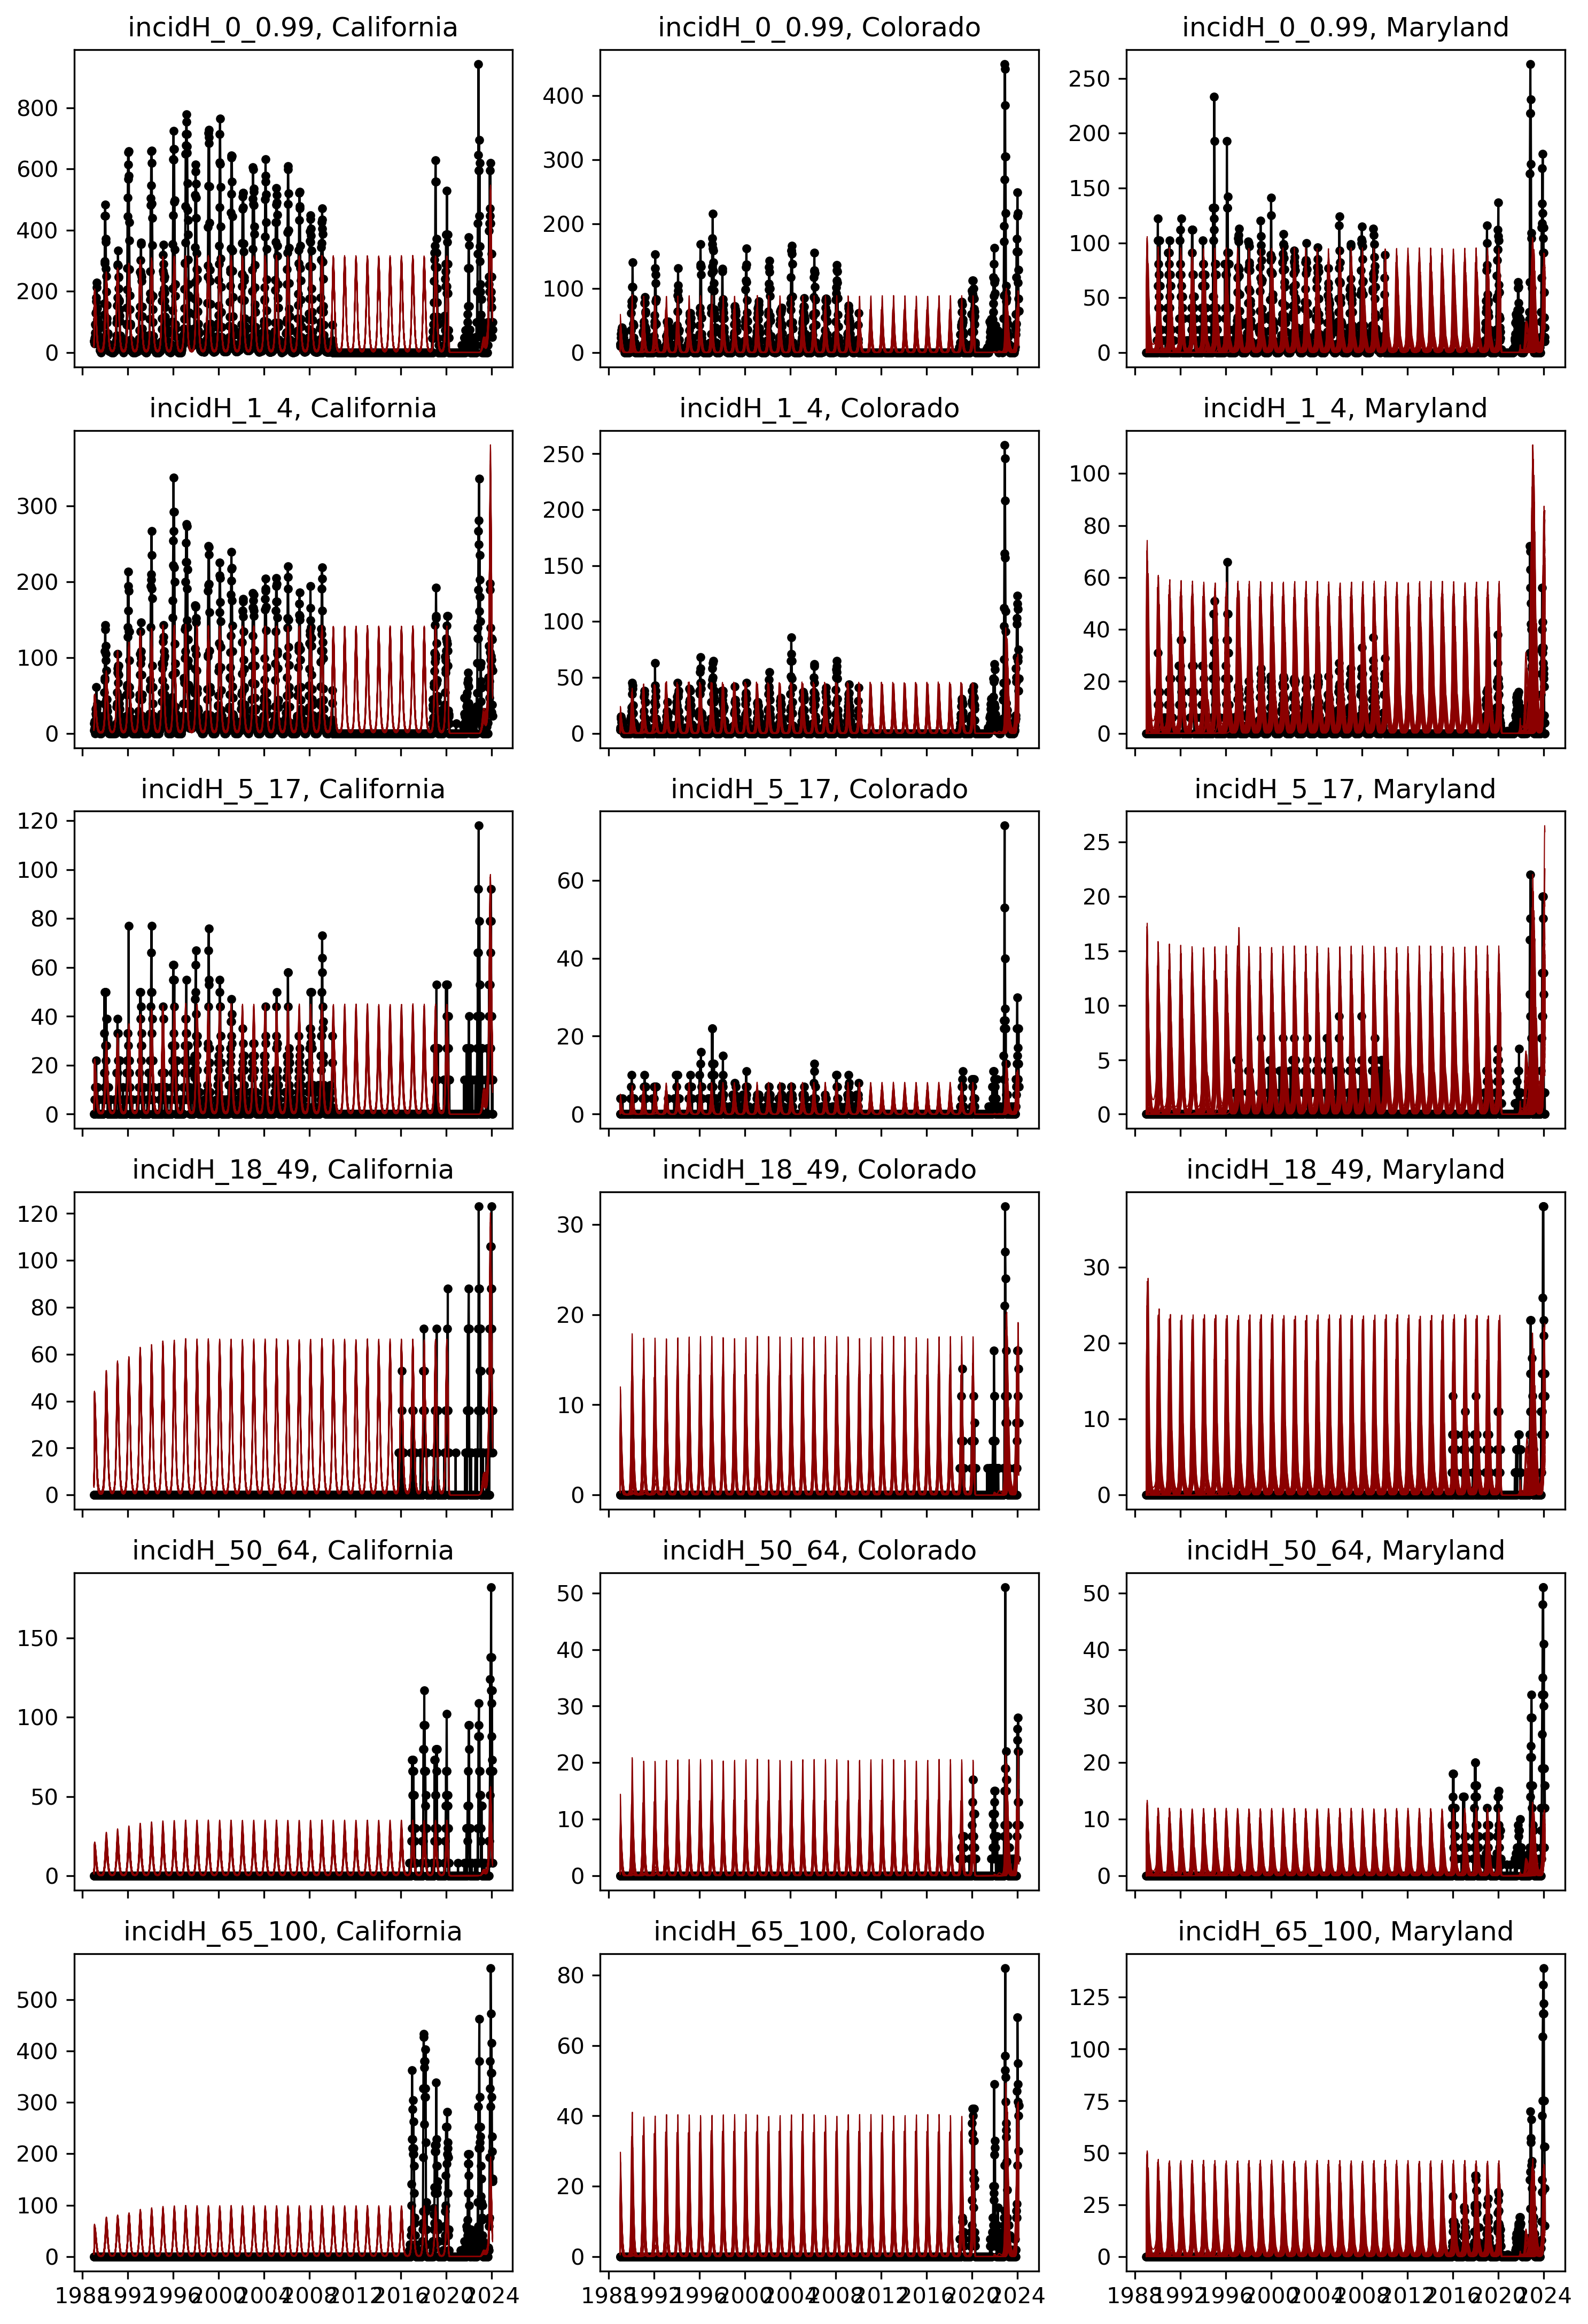

In [57]:
fig, axes = plt.subplots(len(statistics),len(subpop_names), figsize=(5*len(subpop_names), 3*len(statistics)), sharex=True, dpi=300)
for j, subpop in enumerate(modinf.subpop_struct.subpop_names):
        gt_s = gt[gt["subpop"]==subpop].sort_index()
        first_date = max(gt_s.index.min(),results[0].index.min())
        last_date = min(gt_s.index.max(), results[0].index.max())
        gt_s = gt_s.loc[first_date:last_date].drop(["subpop"],axis=1).resample("W-SAT").sum()
        
        for i, (key, value) in enumerate(statistics.items()):
                ax = axes[i,j]
                ax.plot(gt_s[value], color='k', marker='.', lw=1)
                for model_df in results:
                        model_df_s = model_df[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[first_date:last_date].resample("W-SAT").sum() # todo sub subpop here
                        ax.plot(model_df_s[key],  lw=.9, c='darkred', alpha=.5)
                #if True:
                #        init_df_s = outcomes_df_ref[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[min(gt_s.index):max(gt_s.index)].resample("W-SAT").sum() # todo sub subpop here
                ax.set_title(f"{value}, {subpop}")
fig.tight_layout()
plt.savefig(f"{run_id}_results.pdf")

In [ ]:
emcee.__version__

In [ ]:
import corner

In [ ]:
#tau = sampler.get_autocorr_time()
#print(tau)

flat_samples = sampler.get_chain(discard=30, thin=2,flat=True) #discard=100, thin=15, 
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples, labels=labels, #truths=[m_true, b_true, np.log(f_true)]
);